In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [70]:
from sklearn.datasets import make_circles

In [71]:
X,Y = make_circles(n_samples=500, shuffle=True, noise=0.2, random_state=1, factor=0.2)

### Visualising Data

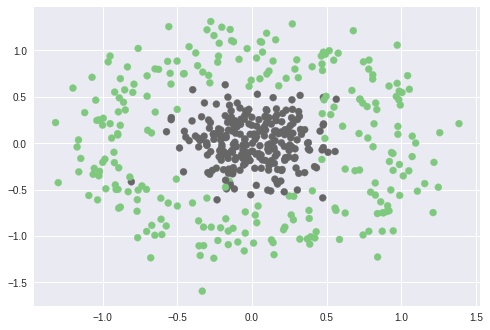

In [73]:
plt.style.use("seaborn")
plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.cm.Accent)
plt.show()

In [258]:
print(X.shape)
print(Y.shape)

(500, 2)
(500,)


### Helper functions for our model

In [170]:
def softmax(a):
    e_pa = np.exp(a) #Vector
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans
def loss(y_oht,y_p):
    l = -np.mean(y_oht*np.log(y_p))
    return l

def one_hot(y):
    classes = len(np.unique(y))
    m = y.shape[0]
    y_oht = np.zeros((m,classes))
    y_oht[np.arange(m),y] = 1
    return y_oht

## Our Neural Network Model

In [368]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size,init_seed=0):
        '''
        input_size : number of inputs (number of features in X)
        layers : list of number of neurons in the hidden layers
        output_size : number of neurons in the Output Layer (number of output classes)
        init_seed : seed for random initialization of weights
        '''
        np.random.seed(init_seed)
        
        model={}
        
        l = len(layers)
        
        #params for first layer
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        #params for last layer/output layer
        model[f'W{l+1}'] = np.random.randn(layers[-1],output_size)
        model[f'b{l+1}'] = np.zeros((1,output_size))
        
        #initialising params for all other layers
        i=2
        for j in range(l-1):
            model[f'W{i}'] = np.random.randn(layers[j],layers[j+1])
            model[f'b{i}'] = np.zeros((1,layers[j+1]))
            
            i+=1
            
        self.model = model
        self.activation_outputs = None    #dict for activations of each layer
        self.n_layers = l    #number of hidden layers
        
        self.summary()

            
    
    def forward(self,X):
        '''
        function for forward propagation
        '''
        a = {}    #activations
        
        l = self.n_layers
        
        #first layer
        z = X @ self.model['W1'] + self.model['b1'] 
        a[1] = np.tanh(z)
        
        #for all hidden layers
        for i in range(2,self.n_layers+1):
            z = a[i-1] @ self.model[f'W{i}'] + self.model[f'b{i}'] 
            a[i] = np.tanh(z)
        
        #output layer
        z = a[l] @ self.model[f'W{l+1}'] + self.model[f'b{l+1}'] 
        a[l+1] = softmax(z)
        
        self.activation_outputs = a
        
        return a[l+1]  #returns the activations of final layer
    
    
    def backward(self,X,Y,learning_rate=0.001):
        '''
        function for doing backward propagation
        
        Y : Y should be m x c one-hot matrix, where m is the number of examples,
            and c is the number of classes
            
        '''
        
        Y_ = self.forward(X)
        a = self.activation_outputs
        layers = self.n_layers
        m = Y.shape[0]
        
        delta = {}    #dictionary for delta^l
        dw = {}       #dictionary for ( del L/del w )^l
        db = {}       #dictionary for ( del L/del b )^l
        
        #for output layer
        delta[layers+1] = Y_ - Y
        dw[layers+1] = a[layers].T @ delta[layers+1]
        db[layers+1] = np.sum(delta[layers+1], axis=0)/m
        
        #for each hidden layer in reverse order
        for l in range(layers,1,-1):
            delta[l] = (1-np.square(a[l])) * (delta[l+1] @ self.model[f'W{l+1}'].T)
            dw[l] = a[l-1].T @ delta[l]
            db[l] = np.sum(delta[l], axis=0)/m
        
        #for first layer (first hidden layer)
        delta[1] = (1-np.square(a[1])) * (delta[2] @ self.model[f'W{2}'].T)
        dw[1] = X.T @ delta[1]
        db[1] = np.sum(delta[1], axis=0)/m
        
        
        #Update model parameters using Gradient Descent
        for i in range(1,l+2):
            self.model[f'W{i}'] -= learning_rate*dw[i]
            self.model[f'b{i}'] -= learning_rate*db[i]
    
    
        
    def predict(self,X):
        '''
        return the final prediction of the network after doing forward propagation
        '''
        preds = self.forward(X)
        
        preds = np.argmax(preds,axis=1)
        
        return preds
    
    
    def summary(self):
        l = self.n_layers
        #prints the shape of weight matrices and biases
        for i in range(1,l+2):
            print('W%d : '%i,self.model[f'W{i}'].shape)
            print('b%d : '%i,self.model[f'b{i}'].shape)
            
            
    def fit(self,X,Y,learning_rate=0.001,epochs=100,batch_size=100,logs=True,return_losses=True):
        '''
        If batch_size<=0 or batch_size>m then do not use batches
        '''
        Y_OHT = one_hot(Y)
        losses=[]
        if batch_size<=0:
            for i in range(epochs):
                model.backward(X,Y_OHT,learning_rate)
                if return_losses:
                    Y_ = model.forward(X)
                    l = loss(Y_OHT,Y_)
                    losses.append(l)
                    if logs:
                        print('Epoch %d, Loss %.4f'%(i+1,l))
            return losses
        else:
            m = X.shape[0]
            for i in range(epochs):
                for batch_start in range(0,m,batch_size):
                    j = batch_start + batch_size
                    #following if condition handels the last batch in case when last batch has less
                    #number of examples than the batch_size 
                    #and it also handels the case when user inputs batch_size>m
                    if j>m:
                        j = m
                    model.backward(X[batch_start:j,:],Y_OHT[batch_start:j],learning_rate)
                    if return_losses:
                        Y_ = model.forward(X)
                        l = loss(Y_OHT,Y_)
                        losses.append(l)
                        if logs:
                            print('Epoch %d, Batch %d, Loss %.4f'%(i+1,int(batch_start/batch_size)+1,l))
            return losses 
        
    def accuracy(self,X,Y):
        print('Accuracy : %.4f'%(np.sum(model.predict(X)==Y)/Y.shape[0]))
                
        

### Training our model

In [405]:
model = NeuralNetwork(2,[4,3],2)

W1 :  (2, 4)
b1 :  (1, 4)
W2 :  (4, 3)
b2 :  (1, 3)
W3 :  (3, 2)
b3 :  (1, 2)


In [406]:
model.accuracy(X,Y)

Accuracy : 0.5080


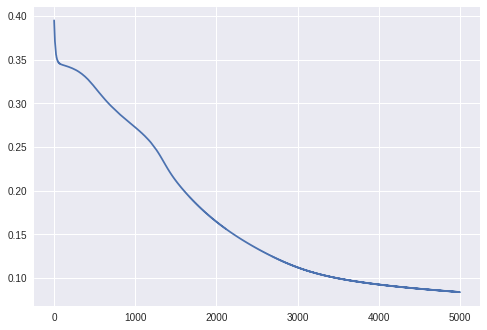

In [407]:
l = model.fit(X,Y,epochs=1000,batch_size=100,logs=False)
plt.plot(l)
plt.show()

In [408]:
model.accuracy(X,Y)

Accuracy : 0.9700


### Visualising Decision Surface

In [409]:
## Plotting decision boundary
from visualize import plot_decision_boundary

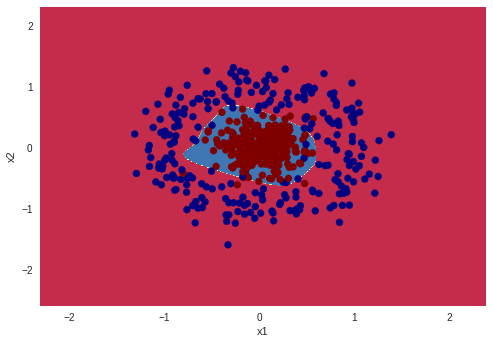

In [410]:
plot_decision_boundary(lambda x:model.predict(x),X,Y)